<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-9.1a" data-toc-modified-id="Figure-9.1a-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 9.1a</a></span></li><li><span><a href="#Figure-9.1b" data-toc-modified-id="Figure-9.1b-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 9.1b</a></span></li><li><span><a href="#Figure-9.2" data-toc-modified-id="Figure-9.2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 9.2</a></span></li><li><span><a href="#Figure-9.3" data-toc-modified-id="Figure-9.3-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 9.3</a></span></li><li><span><a href="#Figure-9.4" data-toc-modified-id="Figure-9.4-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 9.4</a></span></li><li><span><a href="#Figure-9.5" data-toc-modified-id="Figure-9.5-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 9.5</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 9
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import firls, filtfilt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 9.1a

<Figure size 1000x600 with 0 Axes>

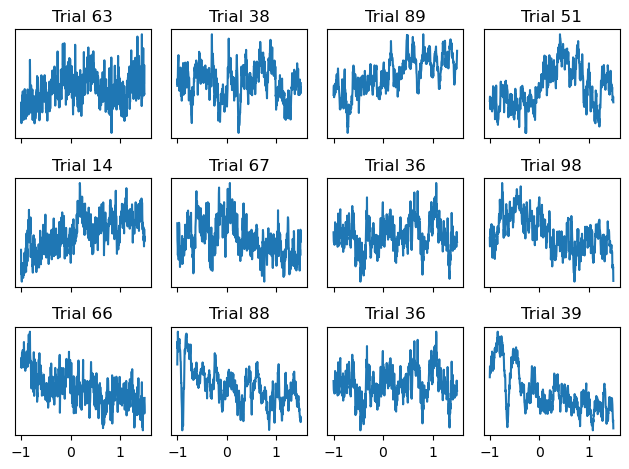

In [4]:
which_channel_to_plot = 'FCz' #specify label of channel to plot
channel_index = chan_labels.index(which_channel_to_plot) #specify index (channel number) of label

x_axis_limit = (-200, 1000) #in milliseconds

num_trials2plot = 12

plt.figure(figsize=(10, 6))
    
# pick a random trials using random.choice (from numpy.random)
random_trial_to_plot = np.random.choice(np.arange(trials), num_trials2plot)

# figure out how many subplots we need
n_rows = np.ceil(num_trials2plot/np.ceil(np.sqrt(num_trials2plot))).astype(int)
n_cols = np.ceil(np.sqrt(num_trials2plot)).astype(int)
fig, ax = plt.subplots(n_rows, n_cols, sharex='all')

for ii in range(num_trials2plot):
    idx = np.unravel_index(ii, (n_rows, n_cols))

    #plot trial and specify x-axis and title
    ax[idx].plot(times, np.squeeze(data[random_trial_to_plot[ii]-1, channel_index,:]))
    ax[idx].set(title=f"Trial {random_trial_to_plot[ii]}", yticks=[])

fig.tight_layout()

## Figure 9.1b

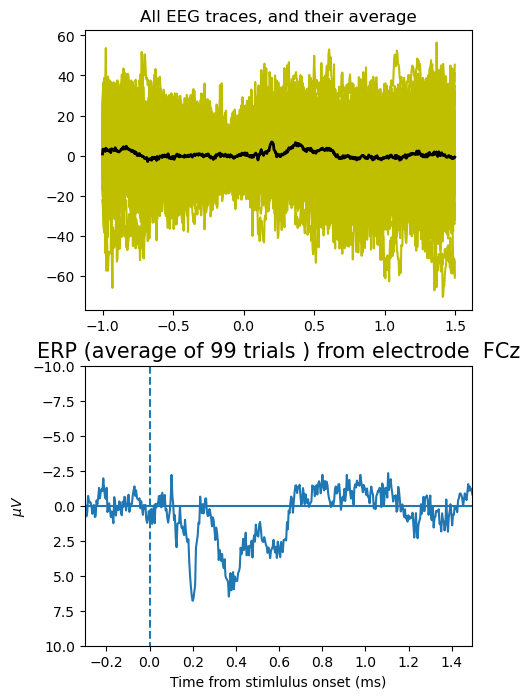

In [5]:
#plot all trials
plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.plot(times, data[:, channel_index,:].T,'y')

#plot the event-related potential (ERP), i.e. the average time-domain signal
plt.plot(times,np.mean(data[:, channel_index,:].T,axis=1),'k',linewidth=2)
plt.title("All EEG traces, and their average")

#now plot only the ERP
plt.subplot(2,1,2)
plt.plot(times,np.mean(data[:, channel_index,:].T,axis=1)) 
plt.vlines(0,-10,10,linestyles='dashed')
plt.hlines(0,tmin,tmax)
plt.axis([-0.3,tmax,-10,10])
plt.xlabel("Time from stimlulus onset (ms)")
plt.ylabel(r'$ \mu V $') 
plt.title(f"ERP (average of {str(trials)} trials ) from electrode  {which_channel_to_plot}", fontsize=15)
plt.gca().invert_yaxis() #EEG convention to flip y axis

## Figure 9.2

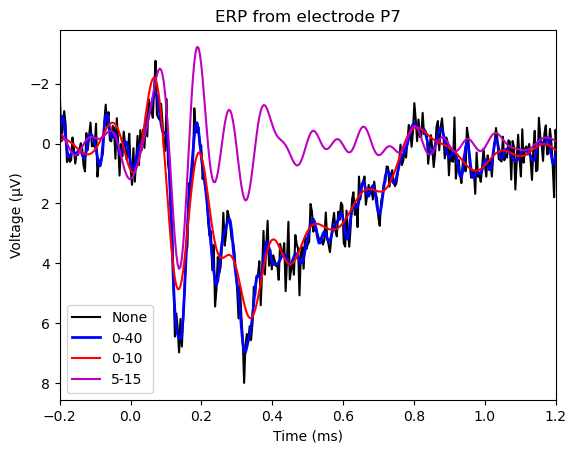

In [6]:
# Pick a channel
chan2plot = 'P7'
channel_index = chan_labels.index(chan2plot) #specify index (channel number) of label

# Compute ERP
erp = np.mean(data[:, channel_index, :].T, axis=1)

# Low-pass filter parameters
nyquist = int(srate) / 2
transition_width = 0.15  # percent

# Filter from 0-40 Hz
filter_cutoff = 40  # Hz
ffrequencies = np.array([0, filter_cutoff, filter_cutoff * (1 + transition_width), nyquist]) / nyquist
idealresponse = [1, 1, 0, 0]
filterweights = firls(101, ffrequencies, idealresponse)
erp_0to40 = filtfilt(filterweights, 1, erp)

# Filter from 0-10 Hz
filter_cutoff = 10  # Hz
ffrequencies = np.array([0, filter_cutoff, filter_cutoff * (1 + transition_width), nyquist]) / nyquist
idealresponse = [1, 1, 0, 0]
filterweights = firls(101, ffrequencies, idealresponse)
erp_0to10 = filtfilt(filterweights, 1, erp)

# Filter from 5-15 Hz
filter_low = 5  # Hz
filter_high = 15  # Hz
ffrequencies = np.array([0, filter_low * (1 - transition_width), filter_low, filter_high, filter_high * (1 + transition_width), nyquist]) / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(np.round(3 * (1+srate / filter_low)), ffrequencies, idealresponse)
erp_5to15 = filtfilt(filterweights, 1, erp)

# Plot all filtered ERPs
plt.figure()
plt.plot(times, erp, 'k', label='None')
plt.plot(times, erp_0to40, 'b', linewidth=2, label='0-40')
plt.plot(times, erp_0to10, 'r', label='0-10')
plt.plot(times, erp_5to15, 'm', label='5-15')

plt.xlim([-0.2, 1.2])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title(f'ERP from electrode {chan2plot}')
plt.legend()
plt.gca().invert_yaxis() #EEG convention to flip y axis

## Figure 9.3

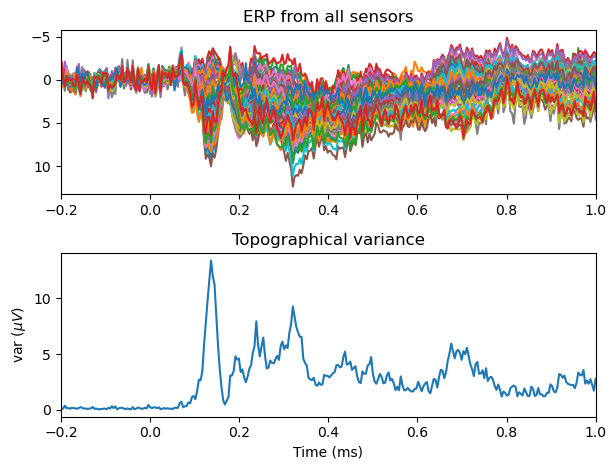

In [7]:
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(times,data.mean(axis=0).T)
plt.xlim([-.2, 1])
plt.gca().invert_yaxis() #flip for EEG conventions
plt.title("ERP from all sensors")

#topographical variance plot

plt.subplot(2, 1, 2)
plt.plot(times,data.mean(axis=0).var(axis=0))
plt.xlim([-.2,1])
plt.xlabel("Time (ms)")
plt.ylabel("var "+r'$ (\mu V) $')
plt.title("Topographical variance")
plt.tight_layout()

## Figure 9.4

In [8]:
# create mne Evoked object

evoked = mne.EvokedArray(data.mean(axis=0)*10**(-6), epochs.info, tmin=tmin) # MNE treats V scale, not micro-volt

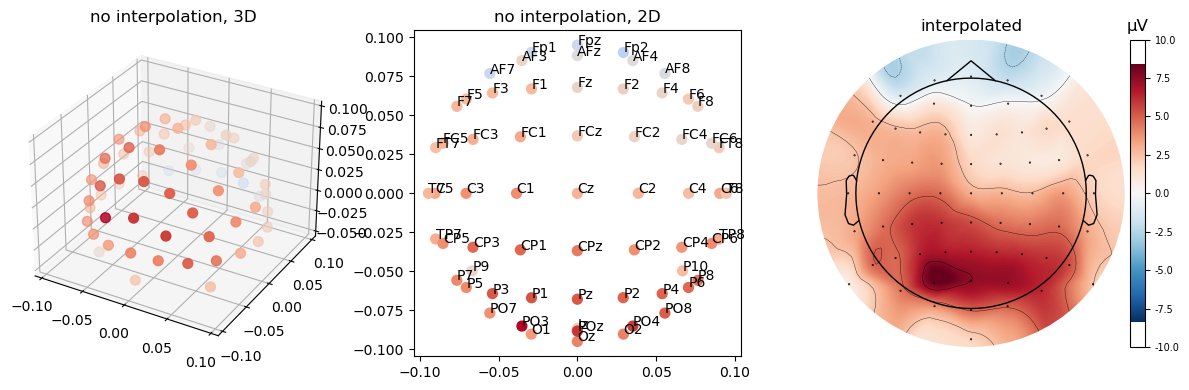

In [9]:
# topoplot with colored dots vs. interpolated surface

# average voltage over trials for a given timepoint
TOI = 300 # ms
c = data.mean(axis=0)[:, np.argmin(abs(times*1000 - TOI))]

# create figure
fig = plt.figure(figsize=(12,4), tight_layout=True)

# plot topomap without interpolation, 3D
clim = np.max(np.abs(c))
ax_1 = fig.add_subplot(1, 3, 1, projection='3d')
ax_1.scatter([pos[0] for pos in chan_pos], [pos[1] for pos in chan_pos], [pos[2] for pos in chan_pos], s=50, c=c, cmap='coolwarm', vmin=-clim,vmax=clim)
ax_1.set(title='no interpolation, 3D')

# plot topomap without interpolation
ax_2 = fig.add_subplot(1, 3, 2)
ax_2.scatter([pos[0] for pos in chan_pos], [pos[1] for pos in chan_pos], s=50, c=c, cmap='coolwarm', vmin=-clim, vmax=clim)
for i in range(len(chan_labels)):
    ax_2.text([pos[0] for pos in chan_pos][i], [pos[1] for pos in chan_pos][i], f"{chan_labels[i]}", fontsize=10)
ax_2.set(title='no interpolation, 2D')

# plot interpolated data
# make colorbar axis
ax_3 = fig.add_subplot(1, 3, 3)
divider = make_axes_locatable(ax_3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax_3.set(title='interpolated')
_=evoked.plot_topomap(times=TOI/1000, axes=(ax_3, cax), time_format='')

## Figure 9.5

In [10]:
EEG_broken = data.copy()*10**-6
channel_index = chan_labels.index('FC4')
EEG_broken[:,channel_index,:] = np.random.randn()*10**-5

evoked_broken = mne.EvokedArray(EEG_broken.mean(axis=0), epochs.info, tmin=tmin)

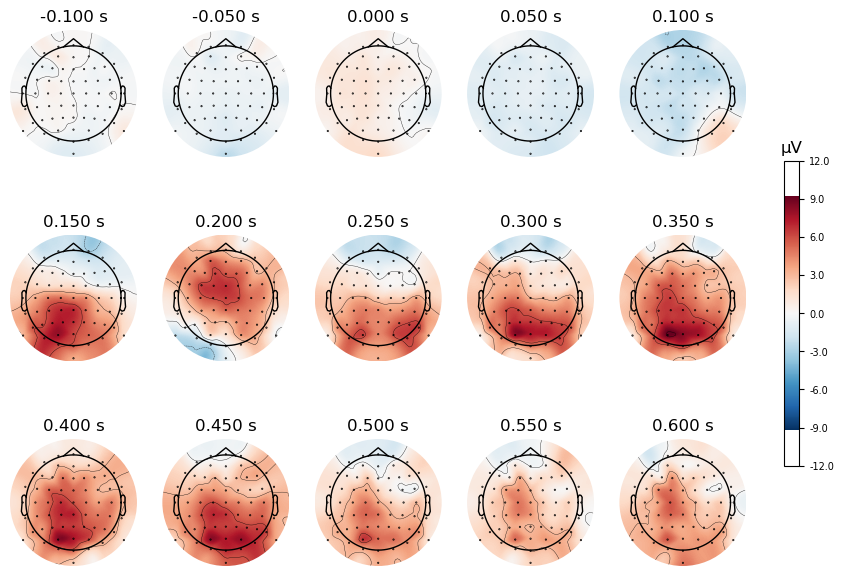

In [11]:
# plot topomap, interpolated surface, 50 ms intervals
_=evoked.plot_topomap(times=np.linspace(-100,600,15)/1000, nrows=3)

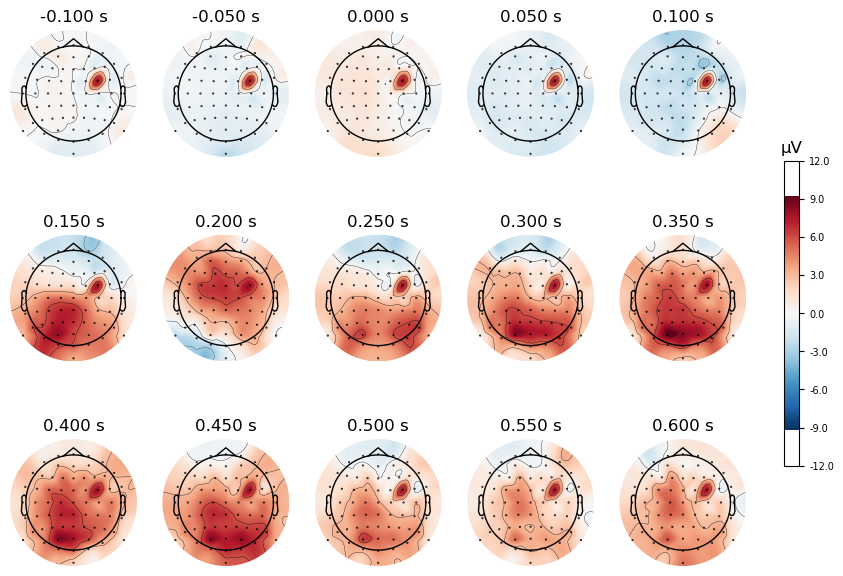

In [12]:
# FC4 broken topomap
_=evoked_broken.plot_topomap(times=np.linspace(-100,600,15)/1000, nrows=3)